# Behavioral Data Analysis

In [2]:
import pandas as pd
from scipy import stats

In [2]:
DATA = pd.read_excel('data/PLB_HYP_data_MASTER.xlsx')
DATA = DATA.dropna(subset='bids_id') # drop the first 9 participants

# Wide to Long
DATA = DATA.melt(id_vars=[
                          'procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
                          'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4',
                          'hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4',
                          'trial_type_1', 'trial_type_2', 'trial_type_3', 'trial_type_4'
                          ],
                 value_vars=['expectancy_1', 'expectancy_2', 'expectancy_3', 'expectancy_4']
                 )

DATA['session'] = DATA['variable'].apply(lambda x:x.split('_')[1])
DATA['procedure'] = DATA.apply(lambda r:r['procedure_type_'+r['session']], axis=1)
DATA['description'] = DATA.apply(lambda r:r['description_type_'+r['session']], axis=1)
DATA['hypnosis_depth'] = DATA.apply(lambda r:r['hypnosis_depth_'+r['session']], axis=1)
DATA['trial_type'] = DATA.apply(lambda r:r['trial_type_'+r['session']], axis=1)

DATA = DATA[['bids_id', 'session', 'trial_type', 'procedure', 'description', 'value', 'hypnosis_depth',]].sort_values(by=['bids_id', 'session'])
DATA = DATA.rename(columns={'value': 'expectancy'})
DATA.reset_index(drop=True, inplace=True)

# replace true values with strings (having boolean values will affect ANOVA result)
DATA = DATA.replace({True: 'real'})

In [3]:
DATA

,bids_id,session,trial_type,procedure,description,expectancy,hypnosis_depth
0,1.0,1,sham,whitenoise,hypnosis,6.0,6.0
1,1.0,2,real,relaxation,control,2.0,7.0
2,1.0,3,real,confusion,hypnosis,6.0,8.0
3,1.0,4,sham,embedded,control,2.0,1.0
4,2.0,1,real,relaxation,control,2.0,1.0
...,...,...,...,...,...,...,...
203,51.0,4,sham,whitenoise,hypnosis,7.0,5.0
204,52.0,1,sham,whitenoise,control,0.0,1.0
205,52.0,2,real,relaxation,hypnosis,3.0,3.0
206,52.0,3,real,confusion,control,3.0,0.0


In [13]:
dep_var = 'hypnosis_depth'
conv = DATA.query("trial_type == 'sham' and description == 'hypnosis'")[dep_var].values
unconv = DATA.query("trial_type == 'real' and description == 'hypnosis'")[dep_var].values

# paired t-test
stats.ttest_rel(conv, unconv)

Ttest_indResult(statistic=-1.3402203372021069, pvalue=0.18315149234014286)

## two-ways ANOVA

In [3]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

<AxesSubplot:ylabel='Frequency'>

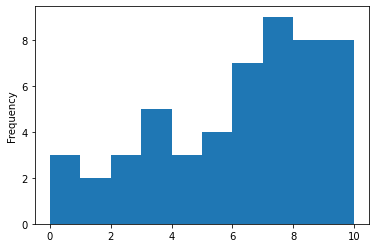

In [22]:
DATA.query("description == 'hypnosis' and trial_type == 'real'")['hypnosis_depth'].plot(kind='hist')

In [6]:
formula = 'hypnosis_depth ~ C(trial_type) + C(description)'
model = ols(formula, DATA).fit()
aov_table = anova_lm(model, typ=2)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(trial_type),55.0433,1.0,6.5930,0.0109
C(description),374.2356,1.0,44.8256,0.0000
Residual,1711.4856,205.0,NaN,NaN


Participants' expectancy is widely dependent to the description type, but not to the trial type.
Hypnosis depth ratings, on the other hand, significantly vary across different both th trial and description types.

## Repeated measure ANOVA

In [24]:
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(DATA, depvar='expectancy', within=['procedure'], subject='bids_id')
res = aovrm.fit()
print(res)

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
procedure  1.0320 3.0000 153.0000 0.3802



### Grid results

In [3]:
# nested grid results
grid_results = pd.read_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv',
                           index_col=0)
# remove plv results
col = [i for i in grid_results.columns if 'plv' in i]
grid_results.drop(columns=col, inplace=True)

grid_results = grid_results.melt()
grid_results[['method', 'signal_type', 'band']] = grid_results['variable'].apply(lambda x:x.split(' ')).apply(pd.Series)
grid_results = grid_results.drop('variable', axis=1).rename({'value':'accuracy'}, axis=1)
grid_results['band']= grid_results['band'].apply(lambda x:x[1:-1])

grid_results

,accuracy,method,signal_type,band
0,0.468750,correlation,source,delta
1,0.593750,correlation,source,delta
2,0.437500,correlation,source,delta
3,0.531250,correlation,source,delta
4,0.437500,correlation,source,delta
...,...,...,...,...
1495,0.548387,wpli,sensor,gamma
1496,0.593750,wpli,sensor,gamma
1497,0.593750,wpli,sensor,gamma
1498,0.612903,wpli,sensor,gamma


In [8]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = 'accuracy ~ C(method) + C(band) + C(signal_type) + C(method):C(band) + C(method):C(signal_type) + C(band):C(signal_type)'
model = ols(formula, grid_results).fit()
aov_table = anova_lm(model, typ=2)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(method),0.7378,2.0,46.7494,0.0
C(band),0.7604,4.0,24.0898,0.0
C(signal_type),0.2872,1.0,36.3981,0.0
C(method):C(band),0.4376,8.0,6.9321,0.0
C(method):C(signal_type),0.8566,2.0,54.2758,0.0
C(band):C(signal_type),0.4570,4.0,14.4763,0.0
Residual,11.6637,1478.0,NaN,NaN


In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
m_comp = pairwise_tukeyhsd(endog=grid_results['accuracy'], groups=grid_results['method'])